nsmc-rtt, petition-rtt,slack-rtt 데이터들의 sentence1을 독일어와 네덜란드어로 RTT후 증강

In [ ]:
from google.cloud import translate_v2 as translate
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm

In [ ]:
def translate_text(text, target_language='ja'):
    """Translates text into the target language."""
    translate_client = translate.Client()
    result = translate_client.translate(text, target_language=target_language)
    return result['translatedText']

In [ ]:
def round_trip_translation(text, intermediate_language='ja'):
    """Performs round-trip translation of text via an intermediate language."""
    # Translate to intermediate language (e.g., English)
    translated_to_intermediate = translate_text(text, target_language=intermediate_language)

    # Translate back to the original language (e.g., Korean)
    translated_back = translate_text(translated_to_intermediate, target_language='ko')

    return translated_back

In [ ]:
# rtt 함수 선언

import requests
global url
url = f"https://translation.googleapis.com/language/translate/v2"

global api_key
api_key = ""


def translate_text(text, target_language):
    url = f"https://translation.googleapis.com/language/translate/v2"

    params = {
        'q': text,
        'target': target_language,
        'key': api_key
    }

    response = requests.get(url, params=params)

    if response.status_code == 200:
        return response.json()['data']['translations'][0]['translatedText']
    else:
        return f"Error: {response.status_code}, {response.text}"

def rtt(text, intermediate_language, final_language):
    intermediate_text = translate_text(text, intermediate_language)
    final_text = translate_text(intermediate_text, final_language)

    return final_text

original_text = "스릴도있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요~"
intermediate_language = "ja"
final_language = "ko"

print(rtt(original_text, intermediate_language, final_language))

스릴도 있고 반전도 있어, 언제나 한국 영화의 쓰레기들과는 차원이 다르네요~


In [ ]:
os.chdir("/content/drive/MyDrive/네이버 부스트캠프 AI Tech 7기/프로젝트 1 - 문장 간 유사도 측정")

In [ ]:
train_pd = pd.read_csv("train.csv")
dev_pd = pd.read_csv("dev.csv")
test_pd = pd.read_csv("test.csv")

print(train_pd.info(),end='\n\n')
print(dev_pd.info(),end='\n\n')
print(test_pd.info(),end='\n\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9324 entries, 0 to 9323
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            9324 non-null   object 
 1   source        9324 non-null   object 
 2   sentence_1    9324 non-null   object 
 3   sentence_2    9324 non-null   object 
 4   label         9324 non-null   float64
 5   binary-label  9324 non-null   float64
dtypes: float64(2), object(4)
memory usage: 437.2+ KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550 entries, 0 to 549
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            550 non-null    object 
 1   source        550 non-null    object 
 2   sentence_1    550 non-null    object 
 3   sentence_2    550 non-null    object 
 4   label         550 non-null    float64
 5   binary-label  550 non-null    float64
dtypes: float64(2), object(4)
memory usage

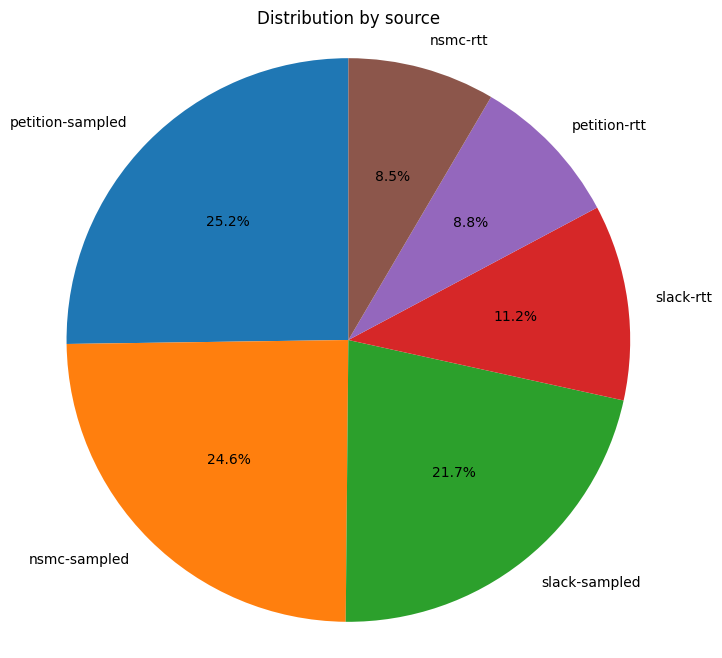

In [ ]:
# source별 데이터 개수 세기
source_counts = train_pd['source'].value_counts()

# 파이 차트 그리기
plt.figure(figsize=(8, 8))
plt.pie(source_counts, labels=source_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution by source')
plt.axis('equal')  # 원형 비율 유지
plt.show()

In [ ]:
print(train_pd["source"].unique())

['nsmc-sampled' 'slack-rtt' 'petition-sampled' 'slack-sampled' 'nsmc-rtt'
 'petition-rtt']


In [ ]:
print(train_pd.columns)

Index(['id', 'source', 'sentence_1', 'sentence_2', 'label', 'binary-label'], dtype='object')


RTT에서 어떤 언어를 선택해야할지 골라야할지 번역 결과를 보고 비교를 해봐야겠다. 먼저 rtt 데이터만의 데이터 프레임을 선언해준다

In [ ]:
# rtt 데이터 df 선언

rtt_categories_names = []
for name in train_pd["source"].unique():
    if name[-3:] == "rtt":
        rtt_categories_names.append(name)

count = 0
count_limit = 10

rtt_df = None

for i in range(len(train_pd)):
    source_name = train_pd.iloc[i]["source"]
    if source_name in rtt_categories_names:
        row = train_pd.iloc[i].copy()
        rtt_df = pd.concat([rtt_df, pd.DataFrame([row])], ignore_index=True)  # rtt_df에 해당 행 추가

rtt_df

,id,source,sentence_1,sentence_2,label,binary-label
0,boostcamp-sts-v1-train-001,slack-rtt,앗 제가 접근권한이 없다고 뜹니다;;,"오, 액세스 권한이 없다고 합니다.",4.2,1.0
1,boostcamp-sts-v1-train-005,nsmc-rtt,오마이가뜨지져스크롸이스트휏,오 마이 갓 지저스 스크론 이스트 팬,2.6,1.0
2,boostcamp-sts-v1-train-006,slack-rtt,전 암만 찍어도 까만 하늘.. ㅠㅠ,암만 찍어도 하늘은 까맣다.. ㅠㅠ,3.6,1.0
3,boostcamp-sts-v1-train-010,slack-rtt,그 책부터 언능 꺼내봐야 겠어요!,책에서 꺼내야겠어요!,2.4,0.0
4,boostcamp-sts-v1-train-012,nsmc-rtt,오랫만에 존쿠삭의 연기보니 좋네요 Good~~!!,오랜만에 존 쿠삭의 연기를 보니 반갑다. 좋아요~~!!,3.8,1.0
...,...,...,...,...,...,...
2647,boostcamp-sts-v1-train-9297,slack-rtt,"크 오늘 날씨 너무 좋았는데, 대박!!","오늘은 날씨가 너무 좋았어, 굿굿!!",4.0,1.0
2648,boostcamp-sts-v1-train-9298,petition-rtt,북한 연락사무소 리모델링 97억8천만원???? 시급한 일이라 사후 계산한다고//,북한연락사무소 리모델링 97억8000만원???? 급하니까 나중에 계산할게 //,4.2,1.0
2649,boostcamp-sts-v1-train-9304,petition-rtt,독도 표시된 한반도기 사용,독도가 표시된 한반도기 사용,5.0,1.0
2650,boostcamp-sts-v1-train-9307,slack-rtt,프로젝트 멘토님을 뵙는 느낌으로 영접하였습니다.,프로젝트 멘토를 만난 기분으로 인사를 받았습니다.,2.8,1.0


일본어로 RTT된 데이터 프레임을 만들어 준다.

In [ ]:
# 증강 될 데이터가 들어갈 데이터프레임 선언 (일본어)
aug_df_ja = None

rtt_categories_names = []
for name in train_pd["source"].unique():
    if name[-3:] == "rtt":
        rtt_categories_names.append(name)

for i in tqdm(range(len(rtt_df))):
    row = rtt_df.iloc[i].copy()
    row["sentence_2"] = "tba"  # 새로 RTT 될 부분만 제거 후 복붙
    aug_df_ja = pd.concat([aug_df_ja, pd.DataFrame([row])], ignore_index=True)  # aug_df에 해당 행 추가

# RTT 된 문장 추가
intermediate_language = "ja" # 일본어 언어코드 ja
final_language = "ko"

for i in tqdm(range(len(aug_df_ja))):
    text = rtt(aug_df_ja.iloc[i]["sentence_1"], intermediate_language, final_language)
    aug_df_ja.loc[i, "sentence_2"] = text

aug_df_ja

100%|██████████| 2652/2652 [11:31<00:00,  3.83it/s]


,id,source,sentence_1,sentence_2,label,binary-label
0,boostcamp-sts-v1-train-001,slack-rtt,앗 제가 접근권한이 없다고 뜹니다;;,액세스 권한이 없다고 말합니다.,4.2,1.0
1,boostcamp-sts-v1-train-005,nsmc-rtt,오마이가뜨지져스크롸이스트휏,오마이가 떠오르고 있습니다.,2.6,1.0
2,boostcamp-sts-v1-train-006,slack-rtt,전 암만 찍어도 까만 하늘.. ㅠㅠ,암을 찍어도 검은 하늘입니다.,3.6,1.0
3,boostcamp-sts-v1-train-010,slack-rtt,그 책부터 언능 꺼내봐야 겠어요!,그 책에서 단어를 꺼내야합니다!,2.4,0.0
4,boostcamp-sts-v1-train-012,nsmc-rtt,오랫만에 존쿠삭의 연기보니 좋네요 Good~~!!,오랜만에 종석의 연기를 보면 좋겠네요 Good~~!!,3.8,1.0
...,...,...,...,...,...,...
2647,boostcamp-sts-v1-train-9297,slack-rtt,"크 오늘 날씨 너무 좋았는데, 대박!!","오늘의 날씨는 매우 좋았습니다만, 대히트!",4.0,1.0
2648,boostcamp-sts-v1-train-9298,petition-rtt,북한 연락사무소 리모델링 97억8천만원???? 시급한 일이라 사후 계산한다고//,북한 연락사무소 개조 97억8천만원? 긴급이니까 사후계산하면 //,4.2,1.0
2649,boostcamp-sts-v1-train-9304,petition-rtt,독도 표시된 한반도기 사용,독도의 한반도 사용,5.0,1.0
2650,boostcamp-sts-v1-train-9307,slack-rtt,프로젝트 멘토님을 뵙는 느낌으로 영접하였습니다.,프로젝트 멘토님을 만나는 느낌으로 받아들였습니다.,2.8,1.0


기존 RTT된 언어가 영어고, 일본어와 영어가 언어적으로 굉장히 멀어서 그런지 RTT 된 느낌도 상당히 다르다.  
예를 들어 2649번 텍스트 "독도 표시된 한반도기 사용"의 영어 RTT 결과는 "독도가 표시된 한반도기 사용"이고, 일본어는 "독도의 한반도 사용"이다. 이 경우 일본어로 RTT된 결과에 영어와 같이 5점을 주면 부적절하다고 판단된다.  
영어로 RTT된 데이터의 라벨 점수를 그대로 사용 하려면 증강된 RTT 결과 텍스트가 영어로 RTT 된 텍스트와 비슷해야 하기 때문에 일본어는 일단 후보군에서 제외 하도록 하겠다.  

같은 어파 (서게르만어파) 인 독일어와 네덜란드어를 적용하면 영어와 비슷할 것으로 기대된다. 한 번 적용해보자.

In [ ]:
# 증강 될 데이터가 들어갈 데이터프레임 선언 (독일어)
aug_df_de = None

rtt_categories_names = []
for name in train_pd["source"].unique():
    if name[-3:] == "rtt":
        rtt_categories_names.append(name)

for i in tqdm(range(len(rtt_df))):
    row = rtt_df.iloc[i].copy()
    row["sentence_2"] = "tba"  # 새로 RTT 될 부분만 제거 후 복붙
    aug_df_de = pd.concat([aug_df_de, pd.DataFrame([row])], ignore_index=True)  # aug_df에 해당 행 추가

# RTT 된 문장 추가
intermediate_language = "de" # 독일어 언어코드: de
final_language = "ko"

for i in tqdm(range(len(aug_df_de))):
    text = rtt(aug_df_de.iloc[i]["sentence_1"], intermediate_language, final_language)
    aug_df_de.loc[i, "sentence_2"] = text

aug_df_de

100%|██████████| 2652/2652 [16:59<00:00,  2.60it/s]


,id,source,sentence_1,sentence_2,label,binary-label
0,boostcamp-sts-v1-train-001,slack-rtt,앗 제가 접근권한이 없다고 뜹니다;;,"아, 접근 권한이 없다고 나오네요.",4.2,1.0
1,boostcamp-sts-v1-train-005,nsmc-rtt,오마이가뜨지져스크롸이스트휏,맙소사,2.6,1.0
2,boostcamp-sts-v1-train-006,slack-rtt,전 암만 찍어도 까만 하늘.. ㅠㅠ,어두운하늘만찍었는데도 하늘이 까맣더라구요.. ㅠㅠ,3.6,1.0
3,boostcamp-sts-v1-train-010,slack-rtt,그 책부터 언능 꺼내봐야 겠어요!,책을 먼저 구해야 할 것 같아요!,2.4,0.0
4,boostcamp-sts-v1-train-012,nsmc-rtt,오랫만에 존쿠삭의 연기보니 좋네요 Good~~!!,오랜만에 존 쿠삭의 연기를 보니 반갑네요.,3.8,1.0
...,...,...,...,...,...,...
2647,boostcamp-sts-v1-train-9297,slack-rtt,"크 오늘 날씨 너무 좋았는데, 대박!!",오늘 날씨가 정말 좋아서 정말 좋았어요!!,4.0,1.0
2648,boostcamp-sts-v1-train-9298,petition-rtt,북한 연락사무소 리모델링 97억8천만원???? 시급한 일이라 사후 계산한다고//,북 연락사무소 97억8천만원 개조???? 긴급한 사항이므로 소급하여 청구하겠습니다.//,4.2,1.0
2649,boostcamp-sts-v1-train-9304,petition-rtt,독도 표시된 한반도기 사용,독도를 표현한 한반도 국기 사용,5.0,1.0
2650,boostcamp-sts-v1-train-9307,slack-rtt,프로젝트 멘토님을 뵙는 느낌으로 영접하였습니다.,마치 프로젝트 멘토를 만난 듯한 인사를 받았습니다.,2.8,1.0


In [ ]:
# 증강 될 데이터가 들어갈 데이터프레임 선언 (네덜란드어)
aug_df_nl = None

rtt_categories_names = []
for name in train_pd["source"].unique():
    if name[-3:] == "rtt":
        rtt_categories_names.append(name)

for i in tqdm(range(len(rtt_df))):
    row = rtt_df.iloc[i].copy()
    row["sentence_2"] = "tba"  # 새로 RTT 될 부분만 제거 후 복붙
    aug_df_nl = pd.concat([aug_df_nl, pd.DataFrame([row])], ignore_index=True)  # aug_df에 해당 행 추가

# RTT 된 문장 추가
intermediate_language = "nl" # 네덜란드어 언어코드: nl
final_language = "ko"

for i in tqdm(range(len(aug_df_nl))):
    text = rtt(aug_df_nl.iloc[i]["sentence_1"], intermediate_language, final_language)
    aug_df_nl.loc[i, "sentence_2"] = text

aug_df_nl

 53%|█████▎    | 1395/2652 [09:01<07:34,  2.77it/s]

일본어보다 독일어와 네덜란드어를 사용했을 때 영어와 조금 더 비슷해보인다. 두 언어를 사용해서 진행하면 되겠다.



In [ ]:
# 증강된 data의 source 구분
for i in range(len(aug_df_de)):
    rtt_df.loc[i, "source"] += "-en"
    aug_df_de.loc[i, "source"] += "-de"
    aug_df_nl.loc[i, "source"] += "-nl"

In [ ]:
print(rtt_df)
print(aug_df_de.head)
print(aug_df_nl.head)

In [ ]:
aug_df_final = pd.concat([train_pd, aug_df_de, aug_df_nl], axis=0)

aug_df_final

In [ ]:
os.getcwd()

In [ ]:
aug_df_final.to_csv("train_augmented_RTT_de_nl.csv", index=False)

In [ ]:
# source별 데이터 개수 세기
source_counts = aug_df_final['source'].value_counts()

# 파이 차트 그리기
plt.figure(figsize=(8, 8))
plt.pie(source_counts, labels=source_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution by source')
plt.axis('equal')  # 원형 비율 유지
plt.show()

In [ ]:
import matplotlib.pyplot as plt
feature = train_pd['label']

plt.figure(figsize=(12,6))
plt.title('train data label count', fontsize=20)
temp = feature.value_counts()
plt.bar(temp.keys(), temp.values, width=0.1)
plt.xticks(temp.keys(), fontsize=8)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
feature = aug_df_final['label']

plt.figure(figsize=(12,6))
plt.title('Augmented Label Count', fontsize=20)
temp = feature.value_counts()
plt.bar(temp.keys(), temp.values, width=0.1)
plt.xticks(temp.keys(), fontsize=8)
plt.show()